# Chapter 7. Sparse Kernel Machines

In [2]:
options(warn=-1)
library(ggplot2)
library(ramify)
library(pracma)
library(yarrr)

## 7.1 Maximum Margin Classifiers

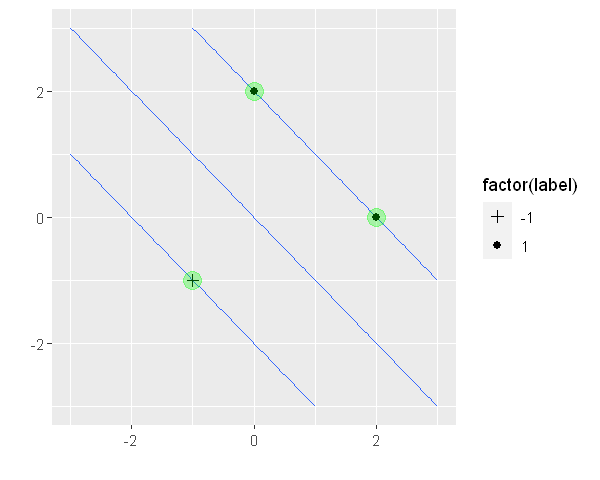

In [4]:
polynomialkernel <- function(x, y, const = 0, degree = 2){
        
        xmat = matrix(0, nrow = 1, ncol = ncol(y))
        for (i in 1:nrow(x)){
                mat =do.call(rbind, replicate(nrow(y), x[i,], simplify=FALSE))
                xmat = rbind(xmat, mat)
        }
        xmat = xmat[-1, ]
        ymat = do.call(rbind, replicate(nrow(x), y, simplify=FALSE))
        xy = xmat * ymat
        
        result = (matrix(rowSums(xy), nrow(x), byrow = T)+ const) ** degree
        return(result)
}


SVC_fit <- function(X, t, tol, Gram, C = Inf){
        nl = ncol(X)
        N = length(t)
        coef = rep(0, N)
        grad = rep(1, N)
        n=0
        while(TRUE){
                #n=n+1
                #print(n)
                tg = t * grad
                mask_up <-  (t == 1) & (coef < C - tol)
                mask_up <- mask_up | (t == -1) & (coef > tol)
                mask_down <-  (t == -1) & (coef < C - tol)
                mask_down <- mask_down |(t == 1) & (coef > tol)
                
                i <- which(mask_up==1)[which.max(tg[mask_up])]
                j <- which(mask_down==1)[which.min(tg[mask_down])]
                
                if (tg[i] < (tg[j] + tol)){
                        b = 0.5 * (tg[i] + tg[j])
                        break
                } else{
                        A = ifelse(t[i] == 1,  C - coef[i], coef[i])
                        B = ifelse(t[j] == 1, coef[j], C - coef[j])
                        direction = (tg[i] - tg[j]) / (Gram[i, i] - 2 * Gram[i, j] + Gram[j, j])
                        direction = min(A, B, direction)
                        coef[i] = coef[i]+　direction * t[i]
                        coef[j] = coef[j]- direction * t[j]
                        grad = grad -direction * t * (Gram[i,] - Gram[j,])
                        
                }
        }
        support_mask = coef > tol
        a = coef[support_mask]
        X = X[support_mask]
        X = matrix(X, ncol = nl, byrow = F)
        t = t[support_mask]
        result <- list("model.a" = a,"model.b" = b, "model.X" = X,"model.t"= t)
        return(result)
}







# distance from the boundary
SVC_distance <- function(model.a, model.t, model.b,  model.kernel){
        AT = matrix(model.a * model.t,1) 
        AK = sweep(model.kernel, 2, AT,"*")
        result <- rowSums(AK) + model.b
        return(result)
}

x_train <- matrix(c(0, 2, 2, 0, -1, -1), nrow = 3, byrow = T)
y_train <- c(1, 1, -1)
x <- expand.grid(s.1 = seq(-3, 3,  length.out=100), 
                 s.2 = seq(-3, 3,  length.out=100))
x <-as.matrix(x)
Gram = polynomialkernel(x_train, x_train, const = 0, degree = 1)
SVC1 <- SVC_fit(x_train, y_train, tol = 1e-8, Gram, C = Inf)
model.a = SVC1$model.a
model.t = SVC1$model.t
model.b = SVC1$model.b
model.X = SVC1$model.X 
model.kernel = polynomialkernel(x,model.X, const = 0, degree = 1)

distance <- SVC_distance(model.a, model.t, model.b,  model.kernel)
testset = as.data.frame(cbind(x,distance))
names(testset) <- c("x", "y", "label")

P = as.data.frame(cbind(x_train,matrix(y_train,ncol=1)))
names(P) <- c("x", "y", "label")
Q = as.data.frame(cbind(model.X, matrix(model.t,ncol=1)))
names(Q) <- c("x", "y", "label") 

options(repr.plot.width=5,repr.plot.height=4)
v <- ggplot(testset, aes(x, y, z = label))
v + stat_contour(breaks=c(-1,0,1))+
        geom_point(data = P, mapping = aes(x, y,shape = factor(label)),size =2) +
        geom_point(data = Q,  mapping = aes(x, y), 
                   alpha = 0.3, size = 5, colour = "green") +
  scale_shape_manual(values=c(3, 16))+
        labs(x ="", y="")
  
# 

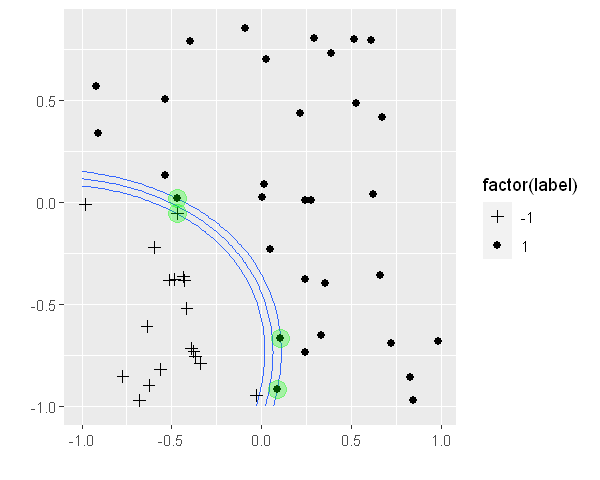

In [5]:

RBFkernel_nd <- function(x, y, params){
  
  x_arr = array(0,dim = c( nrow(y), ncol = ncol(x), nrow(x)))
  
  for (i in 1:nrow(x)){
    c= matrix(x[i,], nrow = nrow(y),ncol = ncol(x), byrow = T)
    x_arr[,,i] = c
  }
  y_arr = array(y,dim = c( nrow(y), ncol = ncol(y), nrow(x)))
  
  d = (x_arr - y_arr)^2
  q = matrix(params[-1],1)
  dp = sweep(d, 2, q,"*")
  
  dsum = matrix(0, nrow = nrow(x),ncol = nrow(y))
  for (j in 1:nrow(x)){
    dsum[j,] = rowSums(dp[,,j])       
  }
  return( params[1] * exp(-0.5 * dsum) )
}





set.seed(1234)
create_toy_data <- function(){
        x = matrix(runif(100, min=-1, max=1), ncol =2)
        y = x < 0
        y2 = y[,1] * y[,2]
        y1 = 1 - 2 * y2
        result <- list("predictor"=x, "reponser"=y1)
        return(result)
}

data = create_toy_data()
x_train = data$predictor
y_train = data$reponser

x <- expand.grid(s.1 = seq(-1,1,  length.out=100), 
                 s.2 = seq(-1,1, length.out=100))
x <-as.matrix(x)
Gram <- RBFkernel_nd(x_train, x_train, c(1,1,1))

SVC1 <- SVC_fit(x_train, y_train, tol = 1e-8, Gram, C = Inf)
model.a = SVC1$model.a
model.t = SVC1$model.t
model.b = SVC1$model.b
model.X = SVC1$model.X 
model.kernel = RBFkernel_nd(x, model.X, params = c(1,1,1))

distance <- SVC_distance(model.a, model.t, model.b,  model.kernel)

testset = as.data.frame(cbind(x,distance))
names(testset) <- c("x", "y", "label")

P = as.data.frame(cbind(x_train,matrix(y_train,ncol=1)))
names(P) <- c("x", "y", "label")
Q = as.data.frame(cbind(model.X, matrix(model.t,ncol=1)))
names(Q) <- c("x", "y", "label") 

v <- ggplot(testset, aes(x, y, z = label))
v + stat_contour(breaks=c(-1,0,1))+
  geom_point(data = P, mapping = aes(x, y,shape = factor(label)),size =2) +
  geom_point(data = Q,  mapping = aes(x, y), 
             alpha = 0.3, size = 5, colour = "green") +
  scale_shape_manual(values=c(3, 16))+
  labs(x ="", y="")



### 7.1.1 Overlapping class distributions

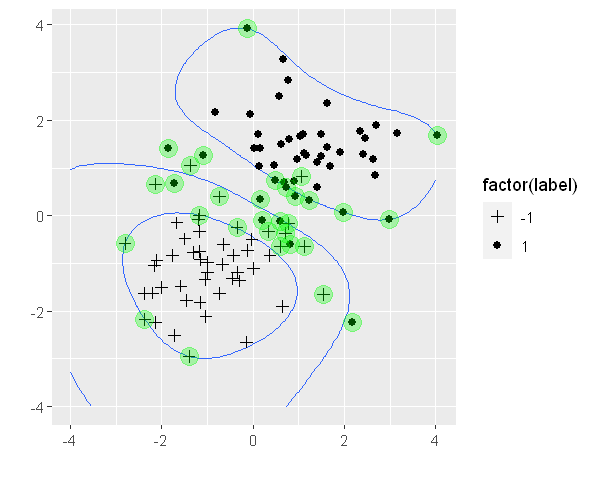

In [6]:

create_toy_data <- function(){
  x0 = -1 + rnorm(100, mean = 0, sd = 1)
  x0 = matrix(x0, ncol=2)
  x1 = 1 + rnorm(100, mean = 0, sd = 1)
  x1 = matrix(x1, ncol=2)
  x = rbind(x0, x1)
  y = c(rep(-1, 50), rep(1, 50))
  result <- list("predictor"=x, "responser"=y)
  return(result)
}
data = create_toy_data()

x_train = data$predictor
y_train = data$responser
x <- expand.grid(s.1 = seq(-4, 4, length.out=100), 
                 s.2 = seq(-4, 4, length.out=100))
x <-as.matrix(x)
Gram <- RBFkernel_nd(x_train, x_train, c(1,0.5, 0.5))

SVC1 <- SVC_fit(x_train, y_train, tol = 1e-8, Gram, C = 1)
model.a = SVC1$model.a
model.t = SVC1$model.t
model.b = SVC1$model.b
model.X = SVC1$model.X 
model.kernel = RBFkernel_nd(x, model.X, params =  c(1,0.5, 0.5))

distance <- SVC_distance(model.a, model.t, model.b,  model.kernel)

testset = as.data.frame(cbind(x,distance))
names(testset) <- c("x", "y", "label")

P = as.data.frame(cbind(x_train,matrix(y_train,ncol=1)))
names(P) <- c("x", "y", "label")
Q = as.data.frame(cbind(model.X, matrix(model.t,ncol=1)))
names(Q) <- c("x", "y", "label") 

v <- ggplot(testset, aes(x, y, z = label))
v + stat_contour(breaks=c(-1,0,1))+
  geom_point(data = P, mapping = aes(x, y,shape = factor(label)),size =2) +
  geom_point(data = Q,  mapping = aes(x, y), 
             alpha = 0.3, size = 5, colour = "green") +
  scale_shape_manual(values=c(3, 16))+
  labs(x ="", y="")

## 7.2 Relevance Vector Machines

### 7.2.1 RVM for regression

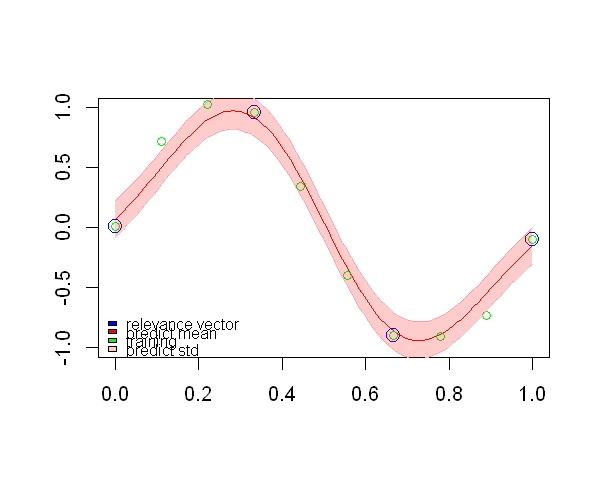

In [42]:

create_toy_data <- function(n=10){
  x = seq(0, 1,length.out = n)
  t = sin(2 * pi * x) + rnorm(n, sd = 0.1)
  result <- list("predictor"=x, "responser"=t)
  return(result)
  
}

RBFkernel <- function(x, y, params){
  
  xmat = matrix(x, nrow=length(y), ncol=length(x), byrow = T)
  pairwise = xmat - y
  
  d.sum = sum(params[-1]) * pairwise^2
  kernel = params[1] * exp(-0.5 * d.sum)
  return(kernel)
}


RVR_fit <- function(X, t, Phi, alpha=1, beta=1, iter_max=1000, klparams){
  N = length(t)
  
  alpha = rep(0, N) + alpha
  for (i in 1:iter_max){
    #print(i)
    params = c( alpha, beta)
    precision = diag(as.vector(alpha)) + beta * t(Phi) %*% Phi
    covariance = solve(precision)
    mean = beta * covariance %*% t(Phi) %*% t
    gamma = 1 - alpha * diag(covariance)
    alpha = gamma / (mean)^2
    alpha = clip(alpha, .min=0, .max=1e10)
    beta = (N - sum(gamma)) / sum((t - dot(Phi, mean)) ** 2)
    #print(mean)
    if (isTRUE(all.equal(params, c(alpha, beta)))) break                              
  }
  mask = alpha < 1e9
  #print(mask)
  X = X[mask]
  t = t[mask]
  alpha = alpha[mask]
  Phi = RBFkernel(X, X, klparams)
  precision = diag(alpha) + beta * t(Phi) %*% Phi
  covariance = solve(precision)
  mean = beta * covariance %*% t(Phi) %*% t
  
  result <- list("model.covariance"=covariance, "model.mean"=mean, 
                 "model.alpha"=alpha, "model.X" = X, "model.t" = t, 
                 "model.beta" = beta)
  return(result)
}

RVR_pred <- function(tstX, trnX,  klparams, mean, covariance, beta){
  
  phi = RBFkernel(tstX, trnX, klparams)
  phi = t(phi)
  pred.mean = phi %*% mean
  pred.var = 1 / beta + rowSums(phi %*% covariance * phi)
  pred.std = sqrt(pred.var)
  result <- list("mean"=pred.mean, "std"= pred.std)
  return(result)
}



data = create_toy_data(n=10)
x_train = data$predictor
y_train = data$responser
x = seq(0, 1,length.out = 100)

Phi = RBFkernel(x_train, x_train, c(1,20))
X <- x_train
t <- y_train
klparams = c(1,20)

fit1 <- RVR_fit(X, t, Phi, alpha=1, beta=1, iter_max=1000,  klparams= c(1,20))

trnX = fit1$model.X
mean = fit1$model.mean
covariance = fit1$model.covariance
beta <- fit1$model.beta

pred1 <- RVR_pred(x,trnX, c(1,20), mean, covariance, beta)
y <- pred1$mean
y_std <- pred1$std
plot(x, y,type="l", col="red", xlab="", 
     ylab="", xlim = c(0,1), ylim = c(-1,1))
points(x_train, y_train, col = "green", cex = 1)
points(fit1$model.X , fit1$model.t, col = "blue", cex = 1.6)

lines(x,y - y_std, col="pink")
lines(x,y + y_std, col="pink")
y1 = y - y_std
y2 = y + y_std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
op <- par(cex=0.8)
legend("bottomleft",bty = "n",
       c("relevance vector","predict mean","training","predict std"),
       fill=c("blue","red","green",rgb(1, 0, 0,0.2)))


### 7.2.3 RVM for classification

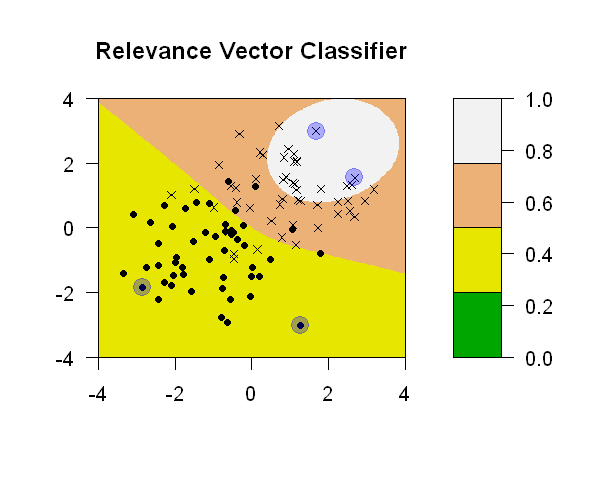

In [50]:
create_toy_data <- function(){
  x0 = matrix(rnorm(100), ncol = 2) - 1
  x1 = matrix(rnorm(100), ncol = 2) + 1
  x = rbind(x0, x1)
  y = c(rep(0, 50), rep(1, 50))
  result <- list("predictor"=x, "responser"=y)
  return(result)
}


map_estimate <- function(Phi, t, w,alpha, n_iter=10){
  for (i in 1:n_iter){
    y = tanh(Phi %*% w * 0.5) * 0.5 + 0.5
    g = t(Phi) %*% (y - t) + alpha * w
    p1 = sweep(t(Phi), 2, y,"*") #每一行操作
    p2 = sweep(p1, 2, 1-y,"*") 
    H = p2 %*% Phi + diag(as.vector(alpha))
    w = w - solve(H, g)
    H.inv = solve(H)
    
  }
  result <- list("w"=w, "H"= H.inv)
  return(result)
}




RBFkernel_nd <- function(x, y, params){
  
  x_arr = array(0,dim = c( nrow(y), ncol = ncol(x), nrow(x)))
  
  for (i in 1:nrow(x)){
    c= matrix(x[i,], nrow = nrow(y),ncol = ncol(x), byrow = T)
    x_arr[,,i] = c
  }
  y_arr = array(y,dim = c( nrow(y), ncol = ncol(y), nrow(x)))
  
  d = (x_arr - y_arr)^2
  q = matrix(params[-1],1)
  dp = sweep(d, 2, q,"*")
  
  dsum = matrix(0, nrow = nrow(x),ncol = nrow(y))
  for (j in 1:nrow(x)){
    dsum[j,] = rowSums(dp[,,j])       
  }
  return( params[1] * exp(-0.5 * dsum) )
}



RVC_fit <- function(X, t, iter_max=100, phi, alpha=1){
      N = length(t)
      alpha = rep(0, N) + alpha
      mean = rep(0,N)
      for (i in 1:iter_max){
        param = alpha
        mean = map_estimate(Phi, t, mean,alpha, 10)$w 
        cov = map_estimate(Phi, t, mean,alpha, 10)$H
        gamma = 1 - alpha * diag(cov)
        alpha = gamma / (mean)^2
        alpha = clip(alpha, .min=0, .max=1e10)
        if (isTRUE(all.equal(param,alpha))) break 
      }
      mask = alpha < 1e8
      X = X[as.vector(mask), ]
      t = t[mask]
      alpha = alpha[as.vector(mask), ]
      Phi = RBFkernel_nd(X, X, c(1., 0.5, 0.5))
      mean = mean[as.vector(mask), ]
      mean = map_estimate(Phi, t, mean, alpha,100)$w
      covariance  = map_estimate(Phi, t, mean,alpha, 100)$H
      result <- list("covariance"=covariance, "mean"=mean, "model.X"=X)
      return(result)
}



RVC__prob <- function(tstX, trnX, klparams, mean, covariance){
  phi = RBFkernel_nd(tstX, trnX, klparams) 
  mu_a = phi %*% mean 
  var_a = rowSums(phi %*% covariance * phi)
  #label = ifelse(phi %*% mean > 0, 1, 0)
  a = mu_a / sqrt(1 + pi * var_a / 8)
  proba = tanh(a * 0.5) * 0.5 + 0.5
  return(proba)
}

data = create_toy_data()
x_train = data$predictor 
y_train = data$responser
x_test <- expand.grid(s.1 = seq(-4, 4, length.out=100), 
                      s.2 = seq(-4, 4, length.out=100))

tstX <- as.matrix(x_test)
klparams <- c(1., 0.5, 0.5)

Phi = RBFkernel_nd(x_train, x_train, c(1., 0.5, 0.5)) #x_train
fit1 <- RVC_fit(x_train, y_train, 100, phi, alpha=1)



y_pred = RVC__prob(tstX, fit1$model.X, c(1., 0.5, 0.5), fit1$mean, fit1$covariance)
y_pred = matrix(y_pred, 100, 100)
filled.contour(x = seq(-4, 4, length.out=100), y = seq(-4, 4, length.out=100), 
               z = y_pred, plot.title = title(main = "Relevance Vector Classifier"),
               levels =c(0, 0.25, 0.5 , 0.75, 1) ,color.palette = terrain.colors, 
               plot.axes = { axis(1); axis(2); points(x_train,pch = ifelse(y_train == 1,4,16), cex=0.8); 
                 points(fit1$model.X, pch = 19,cex=2, 
                        col = transparent("blue", trans.val = .7))})



